In [3]:
# To create tracking statistics and visualizations. 

# Notes on columns:
#     std_pos_x is moving stadard deviation of POSITION between t = k, t = k+std_pos_param
#     std_len_x is moving standard deviation of LENGTH between t = k, t = k+std_len_param
#     md is moving average distance moved between t = k, t = k+md_param
#     correl_A is correlation from -1 to 1; a percent of a traj. at t = k that is in the direction of t = k-1
#     correl_B is correlation without dividing by length from t = k+1
#     correl_A_x, B_x is correlation over window of cor_param
#     center_dist is the distance a particle is from a particular center which will be determined later

# On Parameters:
#     std_pos_param is window for std position calculations
#     std_len_param is window for std length calculations. If std_len_param = 3, STD stored at traj = 3 is std of tracks (1, 2, 3)
#     md_param is window for md calculations. If md_param = 3, MD stored at traj = 3 is mean of length of tracks (1, 2, 3)
#     cor_param is window for correlation calculations. If cor_param = 5, correl_A stored at traj = 5 is mean of correl of tracks (1, 2, 3, 4, 5)  
#     fluo_param is window for fluor. intens. averaging.
#     shell is number of pixels added to the radius to produce sphere of 'nuclear movement'
#     first_frame is the number of the first particle position to consider making radius from - i.e., input 2 = 1 in dict
#     rad_window is frame number to calculate pos_start over - i.e., (avg of [first_frame, first_frame + rad_window])

%matplotlib inline
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import miniball

In [4]:
movie = '03272023'

# Choices: 
# 01312023 (10) - 13 tracks
# 03272023 (10) - 22 tracks
# 06162023 (10) - 16 tracks
# 20220121 (13.5) - 23 tracks

In [5]:
# Load Selected Movie: 
# Change as desired: filename ('path') track_nums_wanted (list), custom (bool), std_len_param (int), md_param (int), cor_param (int)

if movie == '03272023':

    filename = '/Users/andrewperun/LusKing/PT_WT/03272023/SelectedTracks.csv'
    track_nums_wanted = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                    15, 16, 17, 18, 
                    19, 21.1, 21.2, 22, 23]
    first_detection_mip = [64, 9, 70, 50, 23, 6, 27, 19, 13, 54, 75, 14, 6,
                      56, 36, 32, 80,
                      84, 1, 49, 35, 52]

    # The frames at which a spot enters the vacuole
    vaclist = [99, 36, 0, 74, 46, 42, 56, 45, 79, 79, 0, 31, 28, 
              80, 60, 102, 0, 
              105, 33, 72, 0, 0]
    nevlist = [3, 11, 18, 22, 23]

    # Comments:  
    # add one more cell at coord 474, 150 from 02?
    # track 18 begins at t = 80
    # cell 21 has *2* good tracks, labeled 210 and 211
    # skipped 20 for now, multiple spots

    imaging_window = 10    # seconds between image capture_
    
elif movie == '01312023':
    
    filename = '/Users/andrewperun/LusKing/PT_WT/01312023/SelectedTracks-v2.csv' 

    track_nums_wanted = [1, 2, 4, 5, 6.1, 6.2, 7, 10, 12,
                    13, 14, 15, 16]

    # The first detections in MIP for item in track_nums_wanted
    first_detection_mip = [60, 27, 71, 45, 16, 49, 67, 11, 36,
                      44, 12, 5, 60] 

    # The frames at which a spot enters the vacuole
    vaclist = [89, 53, 112, 79, 40, 70, 95, 55, 0,
               70, 51, 0, 77]
    nevlist = [12, 15] 

    # Comments:  
    # Cell 3: -- discarded
    # Cell 5: missing a few detections near end
    # Cell 61: missing at frame 43
    # Cell 8: too many spots, -- find later
    # Cell 9: 2+ particles, sometimes separated by only 0-2 z-stacks, -- use later
    # Cell 11: all on the beginning z-stack glitch, -- discarded
    # Cell 16: missing frame 31 in CSV or 80 in MIP


    imaging_window = 10    # seconds between image capture
    
elif movie == '06162023':
    
    filename = '/Users/andrewperun/LusKing/PT_WT/06162023/SelectedTracks.csv' 

    track_nums_wanted = [1, 2, 3, 4, 5, 6, 8, 10, 12,
                     16, 17, 18, 20,
                     22, 23, 24]

    # The first detections in MIP for item in track_nums_wanted
    first_detection_mip = [21, 28, 51, 30, 71, 93, 26, 37, 28,
                       30, 59, 37, 23,
                       43, 23, 15] 

    # The frames at which a spot enters the vacuole
    vaclist = [54, 55, 72, 85, 99, 0, 55, 79, 79,
              65, 85, 71, 52,
              77, 0, 0]
    
    nevlist = [6, 
               
              23, 24] 

    imaging_window = 10    # seconds between image capture

elif movie == '20220121':
    
    filename = '/Users/andrewperun/LusKing/PT_WT/20220121_13s/SelectedTracks.csv' 
    track_nums_wanted = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                    14, 15, 16,
                    17, 18, 19, 20, 21,
                    22, 23,
                    24
                    ]

    first_detection_mip = [5, 36, 10, 11, 10, 43, 57, 33, 1, 56, 64, 46,
                      42, 53, 37,
                      48, 57, 16, 1, 16,
                      32, 40, 
                      54
                          ]

    # Comments:  
    # Cell 10: only frames 1-25 tracked here, began bouncing all over vacuole
    # Cell 19: in vacuole by 44-45, no significant jump before then. It doesn't necessarily have to jump
    
    vaclist = [40, 70, 33, 39, 0, 60, 78, 0, 26, 79, 91, 66,
              53, 71, 0,
              0, 0, 45, 14, 29,
              45, 51,
              0
              ]
    nevlist = [6, 9, 16, 17, 18, 24] 
    # cell 6 makes it at frame 28, but that is out of range for the track
    # 9 makes it at 51
    # 16 makes it at 63
    # 17 makes it at 69
    # 18 makes it at 75
    # 24 makes it at 83
    
    imaging_window = 13.5      # seconds between image capture
    
    
lab = ["xco","yco","zco","i1","i2","i3","i4","tr_num","dx","dy","dz","dx0","dy0","dz0","dist_from_start","meandist_from_start","meandist_x","msd","std_len_x","len","dxN","dyN","dzN","correl_A", "correl_B", "std_pos_x", "correl_A_x", "correl_B_x", "sigx", "sigy", "sigz", "marker", "fluo_avg", "IvanMetric", "center_dist", "marker2", "ball_rad", "rad_gyr"] # column headers for dfs
df = pd.read_csv(filename, names=lab)



# Load Variable Choices: 

custom = True
window = 2                # std_len_param, std_pos_param >= 2

if custom == True:
    std_pos_param = 4
    std_len_param = 3
    md_param = 1
    cor_param = 2
    fluo_param = 1
    
    shell = 4           
    first_frame = 1
    rad_window = 4
    gyr_rad = 4
    
    mdcut = 4.5
    poscut = 1
    
else:
    print("Using Window")
    std_pos_param = std_len_param = md_param = cor_param = fluo_param = window

In [6]:
# Load Functions: 

# Creates dictionary, returns d
def create_dictionary(dataframe, track_nums_list):
# If we put tracks in a list, append and index them together; if not, take track df and insert into dictionary


    d = {}
    for i in range(len(track_nums_list)):
    
        if isinstance(track_nums_list[i], list):             # If we grouped tracks into a list, we append them together.
            frames = []
            for j in range(len(track_nums_list[i])):
                grouped = df.groupby(df.tr_num)
                dfj = df[df['tr_num'] == track_nums_list[i][j]]   # go through indexes 0 and 1 of [list of tracks to merge]
                frames.append(dfj)
            newdf = pd.concat(frames)                           # concatenate them together
            newdf.index = [k for k in range(len(newdf))]        # indexing rows for concatenated list
            d[i] = newdf
        
        else:
            grouped = df.groupby(df.tr_num)                     # just group tracks not needing ot be merged into their own df
            newdf2 = df[df['tr_num'] == track_nums_list[i]]   # check tracks wanted vs what is in 'tr_num' column
            newdf2.index = [k for k in range(len(newdf2))] # just indexing rows
            d[i] = newdf2
        
    print("Done creating")
    print("Total entries: " + str(len(d)))
    
    return d

# Fills distance from start, differentials, STD of position/length, displacement, fluorescence, correlation metrics
def metrics_dictionary(dictionary, std_pos_param, cor_param, std_len_param, md_param, fluo_param):
    
    #### Distance from start ####
    for i in range(len(d)):
        for k in range(len(d[i])):
        
            # Changes in coordinates from start point, distance from start
            d[i].at[k, 'dx0'] = d[i].at[k, 'xco'] - d[i].at[0, 'xco'] # calculating difference in x-coord from start
            d[i].at[k, 'dy0'] = d[i].at[k, 'yco'] - d[i].at[0, 'yco'] # y-coord from start
            d[i].at[k, 'dz0'] = d[i].at[k, 'zco'] - d[i].at[0, 'zco'] # z-coord from start
            
            # Distance from start by timepoint
            d[i].at[k, 'dist_from_start'] = ((d[i].at[k, 'dx0'] ** 2) + (d[i].at[k, 'dy0'] ** 2) + (d[i].at[k, 'dz0'] ** 2)) ** 0.5 # calculating distance from changes in x, y, z 

        # Meandist is mean distance from start over t=0 to t=j
        for j in range(len(d[i])): 
            dist_sum = 0                                              # set accumulator
            for p in range(-1, j):
                q = p+1
                dist_sum = dist_sum + d[i].at[q, 'dist_from_start']   # summing all distances from t=0 to t=0+p
            d[i].at[j, 'meandist_from_start'] = dist_sum/(j+1)        # dividing sum by row number, assigning meandist_from_start
        
    
    #### Differentials ####
    for i in range(len(d)):
        for j in range(0, (len(d[i])-1)):
            p = j+1
            d[i].at[p, 'dx'] = d[i].at[p, 'xco'] - d[i].at[j, 'xco'] # dx = xco(j+1) - xco(j)
            d[i].at[p, 'dy'] = d[i].at[p, 'yco'] - d[i].at[j, 'yco'] # dy = yco(j+1) - yco(j)
            d[i].at[p, 'dz'] = d[i].at[p, 'zco'] - d[i].at[j, 'zco'] # dz = zco(j+1) - zco(j)
            
    #### STD Of Position over trajectories in std_pos_param ####
    for i in range(len(d)):
        for j in range(std_pos_param-1, (len(d[i]))):
        
            sumx = sumy = sumz = 0                   # set accumulator for sum of x positions
        
            for k in range(j-(std_pos_param)+1, j+1):  # taking sum of (1, 2, ... , std_len_param)
                sumx = sumx + d[i].at[k, 'xco']
                sumy = sumy + d[i].at[k, 'yco']
                sumz = sumz + d[i].at[k, 'zco']

            meanx = sumx / std_pos_param              # mean of x position is sum of positions divided by window
            meany = sumy / std_pos_param
            meanz = sumz / std_pos_param
        
            sum_of_varx2 = sum_of_vary2 = sum_of_varz2 = 0         # set accumulator for sum of the deviation^2 from the mean of x position

            for l in range(j-(std_pos_param)+1, j+1):
                sum_of_varx2 = sum_of_varx2 + ((d[i].at[l, 'xco'] - meanx) ** 2)   # calculating sum of squared deviations
                sum_of_vary2 = sum_of_vary2 + ((d[i].at[l, 'yco'] - meany) ** 2)
                sum_of_varz2 = sum_of_varz2 + ((d[i].at[l, 'zco'] - meanz) ** 2)
        
            sigx = (sum_of_varx2 / std_pos_param) ** 0.5 # taking squared deviations, finding mean to get variance, sqrt(variance) to get STD
            sigy = (sum_of_vary2 / std_pos_param) ** 0.5
            sigz = (sum_of_varz2 / std_pos_param) ** 0.5
    
            d[i].at[j, 'sigx'] = sigx
            d[i].at[j, 'sigy'] = sigy
            d[i].at[j, 'sigz'] = sigz
            d[i].at[j, 'std_pos_x'] = (sigx + sigy + sigz) / 3 # finding mean of STDs of x/y/z-position
            
    #### Correlations ####
    for i in range(len(d)):
        for k in range(len(d[i])):
            d[i].at[k, 'len'] = ((d[i].at[k, 'dx'] ** 2) + (d[i].at[k, 'dy'] ** 2) + (d[i].at[k, 'dz'] ** 2)) ** 0.5 # length of vector using distance formula
            d[i].at[k, 'dxN'] = (d[i].at[k, 'dx']) / (d[i].at[k, 'len']) # Norm(dx) = dx/len
            d[i].at[k, 'dyN'] = (d[i].at[k, 'dy']) / (d[i].at[k, 'len']) # Norm(dy) = dy/len
            d[i].at[k, 'dzN'] = (d[i].at[k, 'dz']) / (d[i].at[k, 'len']) # Norm(dz) = dz/len      
            
        # Finding correl_A/B from non-normalized and normalized vectors
    for i in range(len(d)):
        for j in range(0, (len(d[i]))-1):
            p = j+1
            d[i].at[p, 'correl_A'] = (1/(d[i].at[p, 'len'])) * ( ((d[i].at[p, 'dx'])*(d[i].at[j, 'dxN'])) + ((d[i].at[p, 'dy'])*(d[i].at[j, 'dyN'])) + ((d[i].at[p, 'dz'])*(d[i].at[j, 'dzN'])) )
            d[i].at[p, 'correl_B'] = ((d[i].at[p, 'dx'])*(d[i].at[j, 'dxN'])) + ((d[i].at[p, 'dy'])*(d[i].at[j, 'dyN'])) + ((d[i].at[p, 'dz'])*(d[i].at[j, 'dzN']))

            
        # Averaging correl_A/B over cor_param
    for i in range(len(d)):
    
        for j in range(1+cor_param, len(d[i])): # starting at 1+cor_param because first correl_A, correl_B values are at j = 3, entry "#2"
        
            sumcorA = sumcorB = 0
        
            for k in range(j-cor_param+1, j+1): # taking sum of correlations from j-window to j (with +1 offset for first row)
                sumcorA = sumcorA + d[i].at[k, 'correl_A']
                sumcorB = sumcorB + d[i].at[k, 'correl_B']
            
            d[i].at[j, 'correl_A_x'] = sumcorA / cor_param # average of corellation sum over window
            d[i].at[j, 'correl_B_x'] = sumcorB / cor_param
            
    #### STD of Trajectory Length over std_len_param ####
    for i in range(len(d)):
        for j in range(std_len_param, (len(d[i]))):
        
            sum = 0                   # set accumulator for mean of (1, 2, ... , std_len_param; 2, 3, ... , std_len_param+1)
            sum_of_var2 = 0           # set accumulator for sum of the variances from the mean
        
            for k in range(j-(std_len_param-1), j+1):  # taking sum of (1, 2, ... , std_len_param)
                sum = sum + d[i].at[k, 'len']

            meansum = sum / std_len_param              # mean of sum is sum divided by x window
            for l in range(j-(std_len_param-1), j+1):
                sum_of_var2 = sum_of_var2 + ((d[i].at[l, 'len'] - meansum) ** 2)   # calculating sum(variances from mean, squared)
        
            meansum_of_var2 = sum_of_var2 / std_len_param   # mean of squared variances is sum of squared variances divided by x window
            d[i].at[j, 'std_len_x'] = (meansum_of_var2) ** 0.5   # writing sqrt(mean of squared variances) into std_len_x at j

    #### Mean Trajectory Length over md_param ####
    for i in range(len(d)):
        for j in range(md_param, (len(d[i]))):
        
            sum = 0                                # set accumulator for mean of (1, 2, ... , md_param; 2, 3, ... , md_param+1)
            for k in range(j-(md_param-1), j+1):  # taking sum of (1, 2, ... , md_param)
                sum = sum + d[i].at[k, 'len']
            
            d[i].at[k, 'meandist_x'] = sum / md_param              # mean of sum is sum divided by x window

        
    #### Mean Flourescence Intensity over fluo_param ####
    for i in range(len(d)):
        for j in range(fluo_param, (len(d[i]))):
        
            sum = 0                                # set accumulator for mean of (1, 2, ... , md_param; 2, 3, ... , md_param+1)
            for k in range(j-(fluo_param-1), j+1):  # taking sum of (1, 2, ... , md_param)
                sum = sum + d[i].at[k, 'i3']
            d[i].at[k, 'fluo_avg'] = sum / fluo_param              # mean of sum is sum divided by x window    
    
    return d


def radius_dictionary(d, first_frame, rad_window, shell, gyr_rad):
    # Parameters:
    # d: dictionary of tracks at d[i]
    # first_frame: the first frame we count when finding the 'center' of gyration
    # rad_window: the number of frames we use to find the original 'center' of where the particle condenses
    # shell: extra radius, in px, to add to radius_list (unused list)
    # gyr_rad: number of frames in which to find the radius of gyration
    
    center_list = []    # a list of arrays, going to be a list of list of ints
    radius_list = []    # a list of arrays, going to be a lists of ints

    for i in range(len(d)):
    
        small_list = []  # a list, will append position arrays to it
        for j in range(rad_window):
            small_list.append(np.array([d[i].at[first_frame + j, 'xco'], d[i].at[first_frame + j, 'yco'], d[i].at[first_frame + j, 'zco']]))
        coord_arr = np.array(small_list)
    
        C, r2 = miniball.get_bounding_ball(coord_arr)
        C = C.tolist()
        C = [float(str(elem)) for elem in C]
    
        center_list.append(C)
        radius_list.append(float(str(r2 ** 0.5)) + shell)

        # Computing distance from the center for those centers in list center_dist   
    for i in range(len(d)):
        for j in range(len(d[i])):
        
            d[i].at[j, 'center_dist'] = (((d[i].at[j, 'xco'] - center_list[i][0]) ** 2) + ((d[i].at[j, 'yco'] - center_list[i][1]) ** 2) + ((d[i].at[j, 'zco'] - center_list[i][2]) ** 2)) ** 0.5

        
        # Computing radius of last x points at t=x
    for i in range(len(d)):
        for j in range(1, len(d[i])):
            coord_list = []
            for k in range(1, j+1):
                coord_list.append(np.array([d[i].at[k, 'xco'], d[i].at[k, 'yco'], d[i].at[k, 'zco']]))
            cum_coord_arr = np.array(coord_list)
            C, r2 = miniball.get_bounding_ball(cum_coord_arr)
            d[i].at[j, "ball_rad"] = r2 ** 0.5

        
        # Radius of Gyration
    for i in range(len(d)):
        for j in range(gyr_rad-1, len(d[i])):
            coord_list = []
            for k in range(j-gyr_rad+1, j):
                coord_list.append(np.array([d[i].at[k, 'xco'], d[i].at[k, 'yco'], d[i].at[k, 'zco']]))
            cum_coord_arr = np.array(coord_list)
        
            C, r2 = miniball.get_bounding_ball(cum_coord_arr)
            d[i].at[j, "gyr_rad"] = r2 ** 0.5
    
    return d


def display_dictionary(d):
    COLOR='blue'
    RESFACT=10
    MAP='winter'

    cm = plt.get_cmap(MAP)

    for i in range(len(d)):
        
        # Arranging Data
        
        A = B = C = []
        k = window - 1  
        NPOINTS = len(d[i])
        lenseries = np.asarray([k for k in range(len(d[i]))])
        xco_array = np.asarray(d[i]['xco'])
        yco_array = np.asarray(d[i]['yco'])
        z_max = d[i]['zco'].max()
        z_min = d[i]['zco'].min()
        z_colors  = [str((frac-z_min)/(z_max-z_min)) for frac in d[i]['zco']]
        
    #     if d[i].at[1, 'tr_num'] not in zeroslist:  # Marking where cutoff is met
    #         for m in range(len(cutofflist)):
    #             if cutofflist[m][0] == d[i].at[1, 'tr_num']:
    #                 z_colors[cutofflist[m][1]] = 'red'
                    
                    
                    ####
    #     if d[i].at[1, 'tr_num'] not in nevlist:   # marking where enters vac from vaclist
    #         z_colors[vaclist[i]-first_detection_mip[i]] = 'fuchsia'
    #     mip_vac = vaclist[i]-first_detection_mip[i]
    #                 ####
        
        A = ['STD of Length', d[i]['std_len_x'].to_numpy()]      
        B = ['STD of Position', d[i]['std_pos_x'].to_numpy()]          
        C = ['Mean Distance', d[i]['meandist_x'].to_numpy()]
        D = ['F. Intens.', d[i]['i3'].to_numpy()] # use i3 for f. int. at each point, use fluo_avg for average
        E = ['Dist. from Center', d[i]['center_dist'].to_numpy()]
        F = ['Ball Radius', d[i]['ball_rad'].to_numpy()]
        G = ['Correlation', d[i]['correl_B_x'].to_numpy()]
        H = ['Rad. Gyr.', d[i]["gyr_rad"].to_numpy()]
        
        plotlist = [A, B, C, D, E, F, G, H]  
        
        # Create the Figure
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), width_ratios=[.3, .7])
        
        for point in range(len(xco_array)):
            ax1.plot(np.asarray(xco_array[point]), np.asarray(-yco_array[point]), '-o', c=z_colors[point])
        
        ax1.set_prop_cycle(color=[cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
        
        for points in range(NPOINTS-1):
            ax1.plot(xco_array[points:points+2],-yco_array[points:points+2])
            
        for line in range(0, len(xco_array), 4):
            ax1.annotate(str(line+first_detection_mip[i]), xy=(xco_array[line]+0.4, -yco_array[line]-0.4), xycoords='data')
        
        
        Position = ax2.plot(lenseries, plotlist[1][1], color = 'darkgreen', label = "STD_pos, Green", linewidth = 1.5)
        MeanDist = ax2.plot(lenseries, plotlist[2][1], color = 'dodgerblue', label = "MeanDist, Blue", linestyle = '-', linewidth = 2)
        CenterDist = ax2.plot(lenseries, plotlist[4][1], color='palevioletred', linestyle='-.', label = 'CenterDist', linewidth = 2)
        #BallRad = ax2.plot(lenseries, plotlist[5][1], color='red', linestyle='solid', label = 'BallRad', linewidth = 1.5)
        GyrRad = ax2.plot(lenseries, plotlist[7][1], color='darkorange', linestyle='-.', label ='Rad. Gyr.', linewidth=2)
        
        ax2a=ax2.twinx()
        #Correl = ax2a.plot(lenseries, plotlist[6][1], color='green', linestyle = 'solid', label = 'correl', linewidth = 2)
        
        first_det = " ".join(["First MIP Frame: ",str(first_detection_mip[i])])
        firstline = ax2a.axvline(x=0, ymin=0, ymax=0, label=first_det)
        
#         if d[i].at[1, 'tr_num'] not in zeroslist:
#             for m in range(len(cutofflist)):
#                 if cutofflist[m][0] == d[i].at[1, 'tr_num']:
#                     ax2.axvline(x=cutofflist[m][1], ymin=0, ymax=1, linestyle = 'dotted', color='black', label="Cutoff", linewidth = 2)
#                     cut_time = cutofflist[m][1]
        
        ax2.set_ylim([0, 15]) #  15
        ax2.set_xlim([0, 50])
        ax2.set_ylabel('Pixels', fontsize=14)
        ax2.set_xlabel('Frames', fontsize=14)
        fig.suptitle("Track " + str(d[i].at[0, "tr_num"]), fontsize=17 )
        lines1, labels1 = ax2a.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        lines = lines1 + lines2
        labels = labels1 + labels2
        ax2.legend(lines, labels, loc='best')
        
        # Legend
        # cutoff: how many frames since beginning when cutoff was hit
        # vac: how many frames sicne beginning when in vacuole
    #     legend_drawn_flag = True
    #     if vaclist[i] == 0:
    #         ax1.legend(["cutoff: " + str(cut_time)])
    #     else:
    #         ax1.legend(["cutoff: " + str(cut_time), "vac: " + str(mip_vac)])
        
    #     fig.tight_layout()
    return fig


def highResPoints(x,y,factor=10):
    '''
    Take points listed in two vectors and return them at a higher
    resultion. Create at least factor*len(x) new points that include the
    original points and those spaced in between.

    Returns new x and y arrays as a tuple (x,y).
    '''

    # r is the distance spanned between pairs of points
    r = [0]
    for i in range(1,len(x)):
        dx = x[i]-x[i-1]
        dy = y[i]-y[i-1]
        r.append(np.sqrt(dx*dx+dy*dy))
    r = np.array(r)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = []
    for i in range(len(r)):
        rtot.append(r[0:i].sum())
    rtot.append(r.sum())

    dr = rtot[-1]/(NPOINTS*RESFACT-1)
    xmod=[x[0]]
    ymod=[y[0]]
    rPos = 0 # current point on walk along data
    rcount = 1 
    while rPos < r.sum():
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        dpos = rPos-rtot[rcount] 
        theta = np.arctan2((x2-x1),(y2-y1))
        rx = np.sin(theta)*dpos+x1
        ry = np.cos(theta)*dpos+y1
        xmod.append(rx)
        ymod.append(ry)
        rPos+=dr
        while rPos > rtot[rcount+1]:
            rPos = rtot[rcount+1]
            rcount+=1
            if rcount>rtot[-1]:
                break

    return xmod,ymod


Done creating
Total entries: 22


/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_62081/286114110.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[i].at[j, "gyr_rad"] = r2 ** 0.5
/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_62081/286114110.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[i].at[j, "gyr_rad"] = r2 ** 0.5
/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_62081/286114110.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

/var/folders/cp/13y3b68j0tz9h3vtqsf6lb400000gn/T/ipykernel_62081/286114110.py:268: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), width_ratios=[.3, .7])


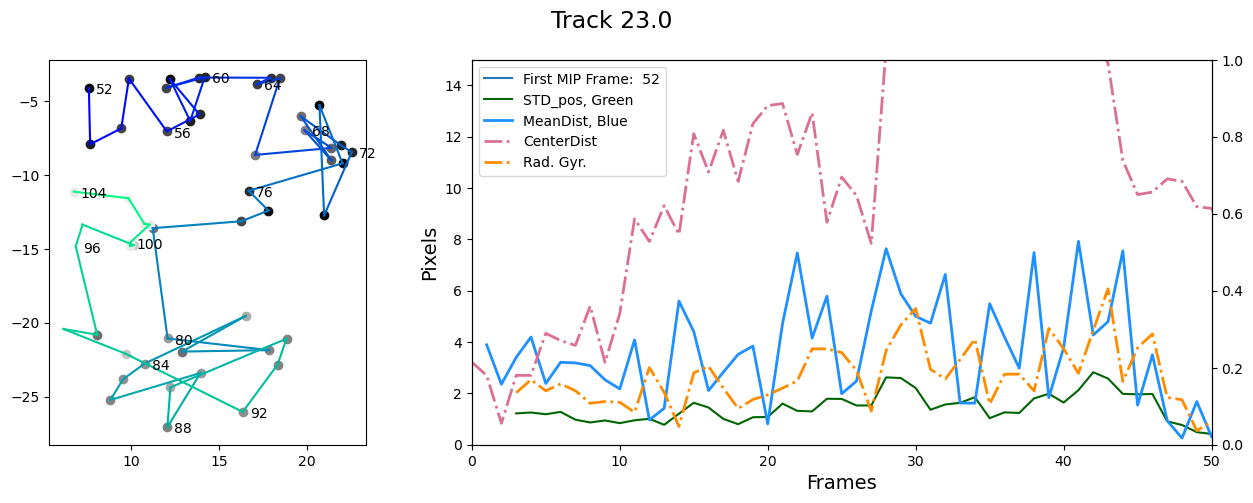

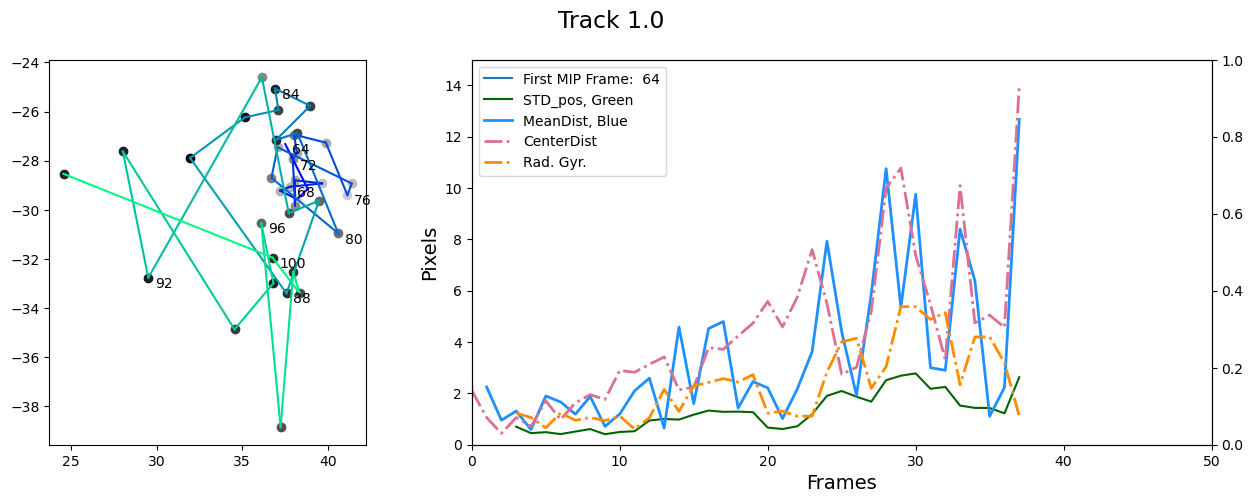

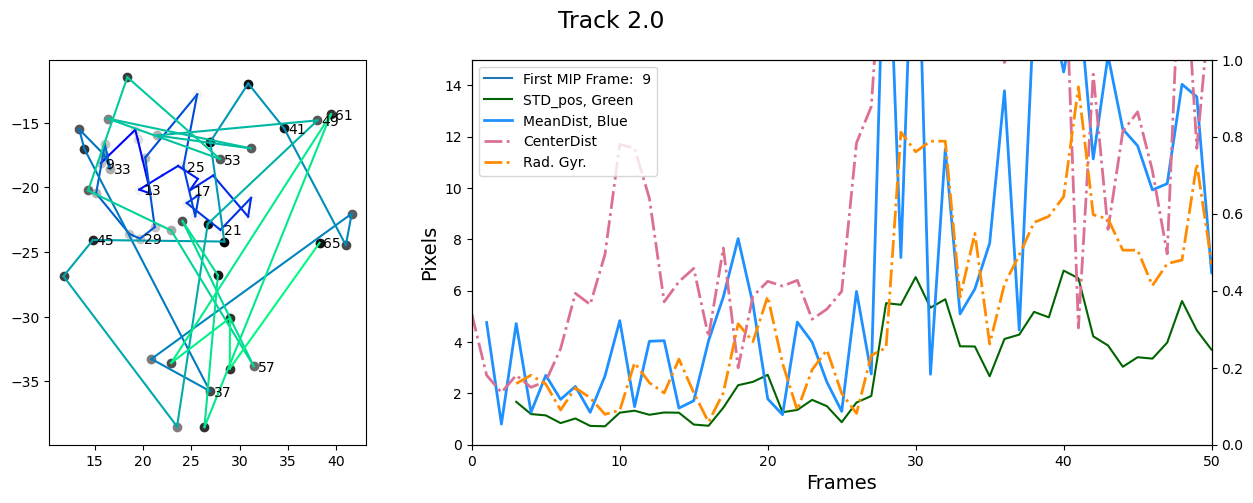

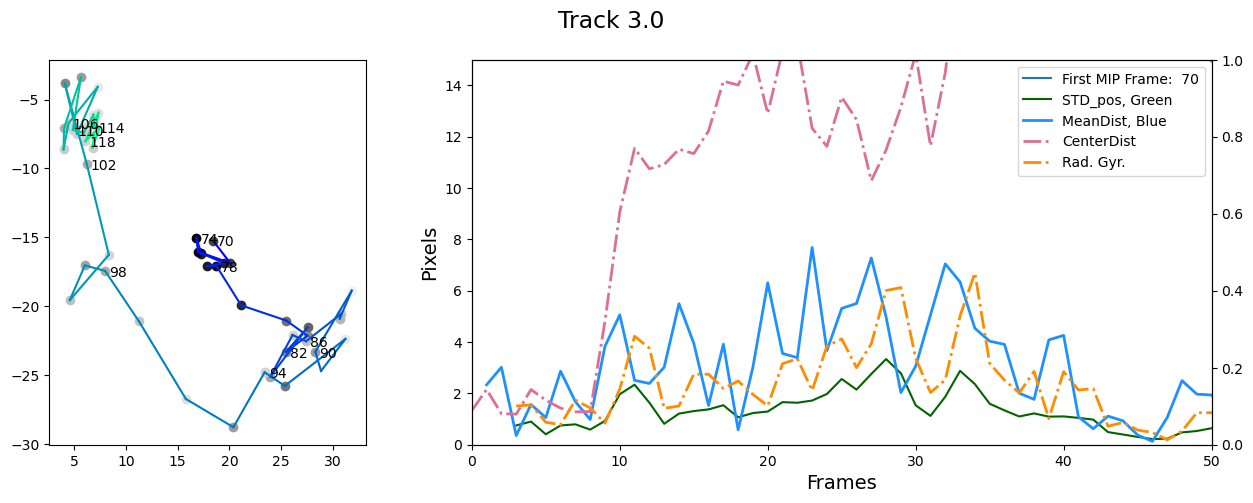

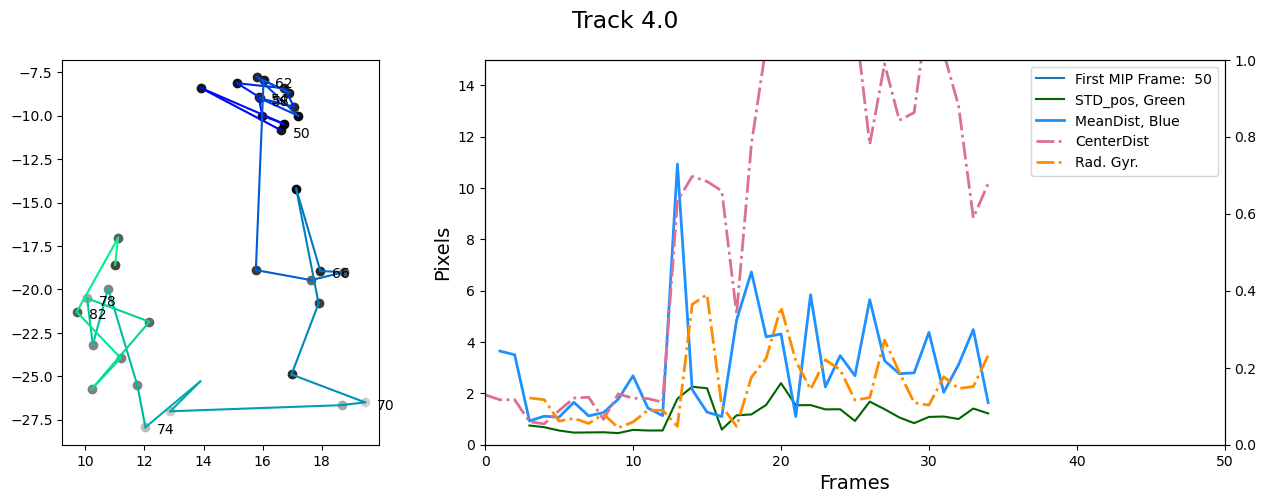

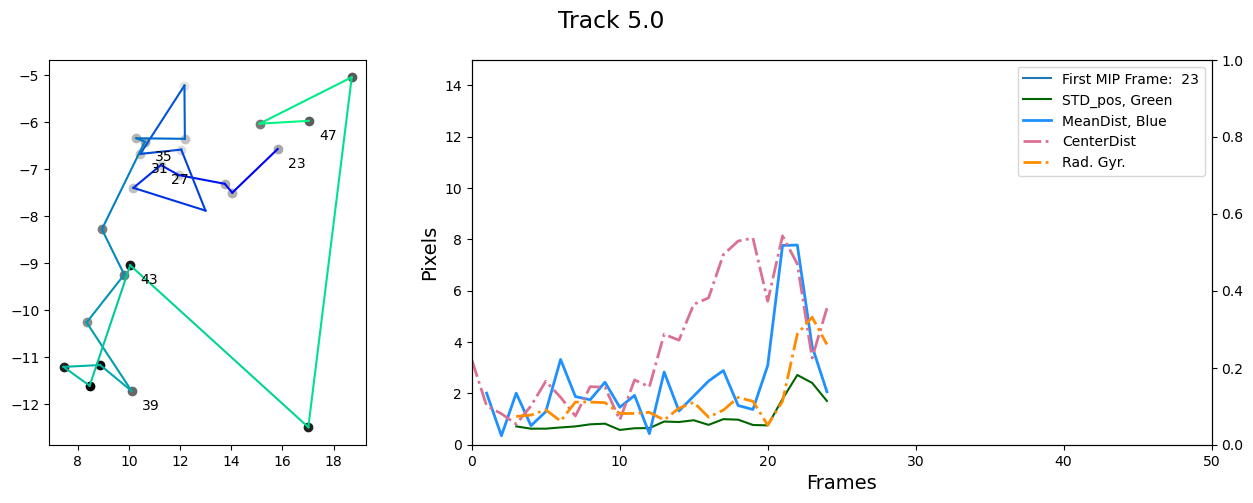

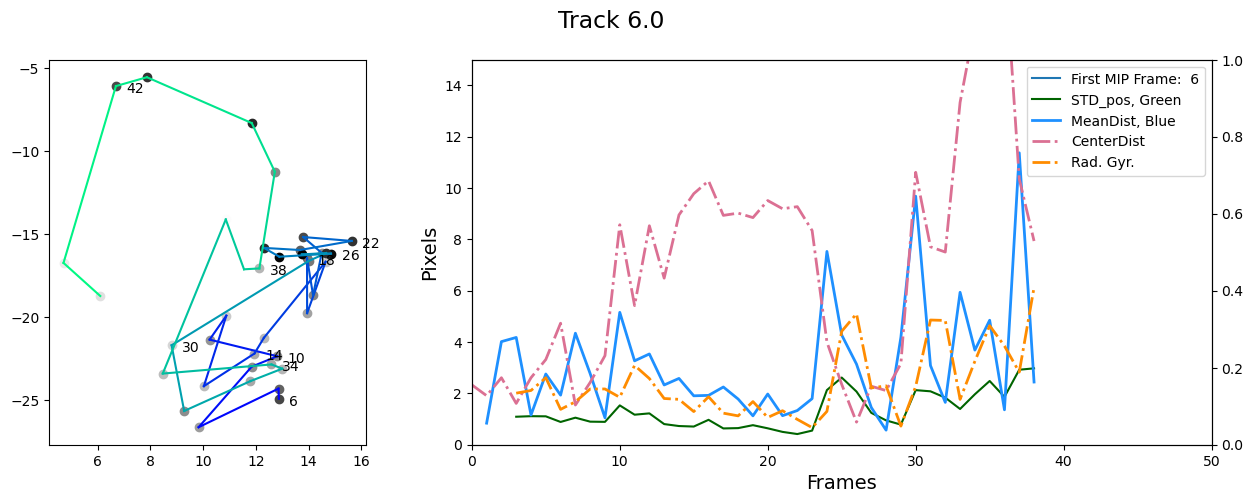

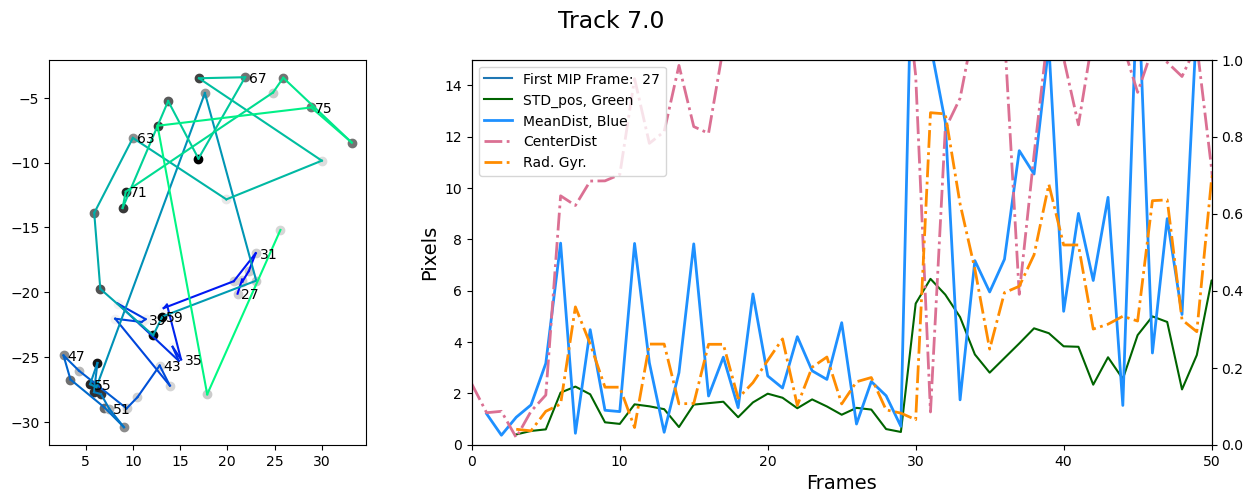

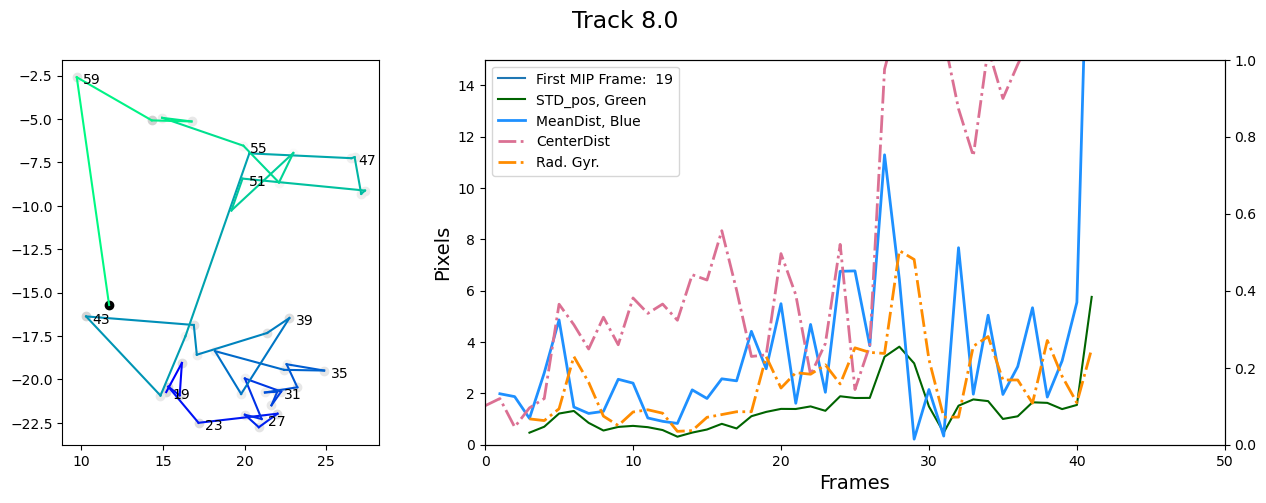

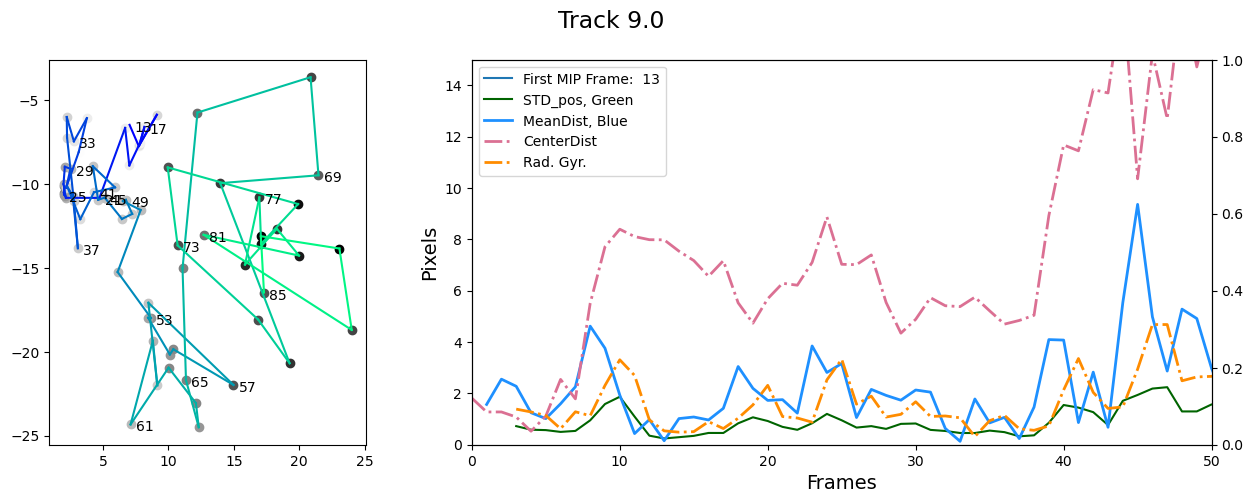

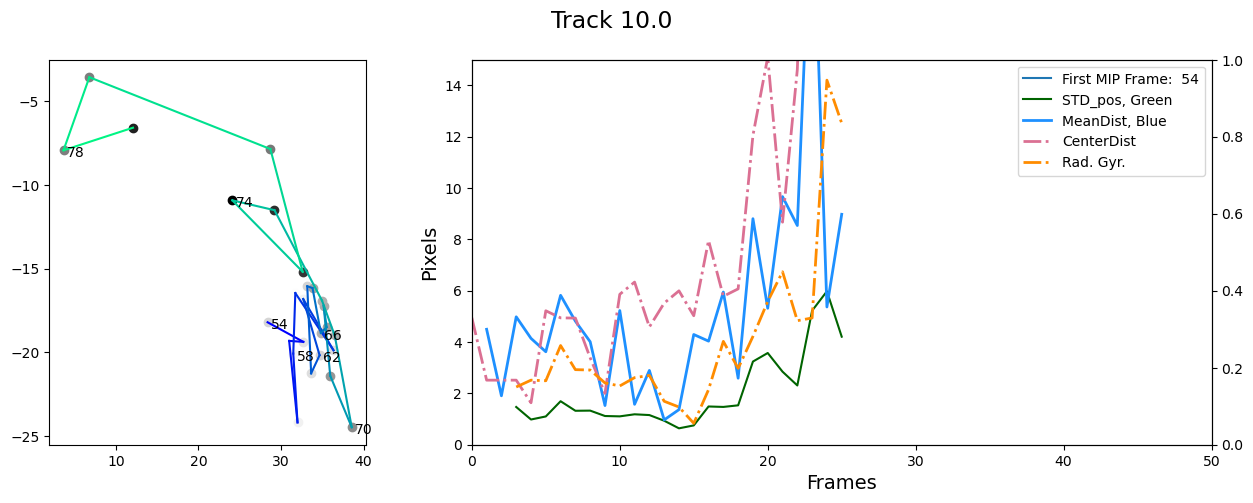

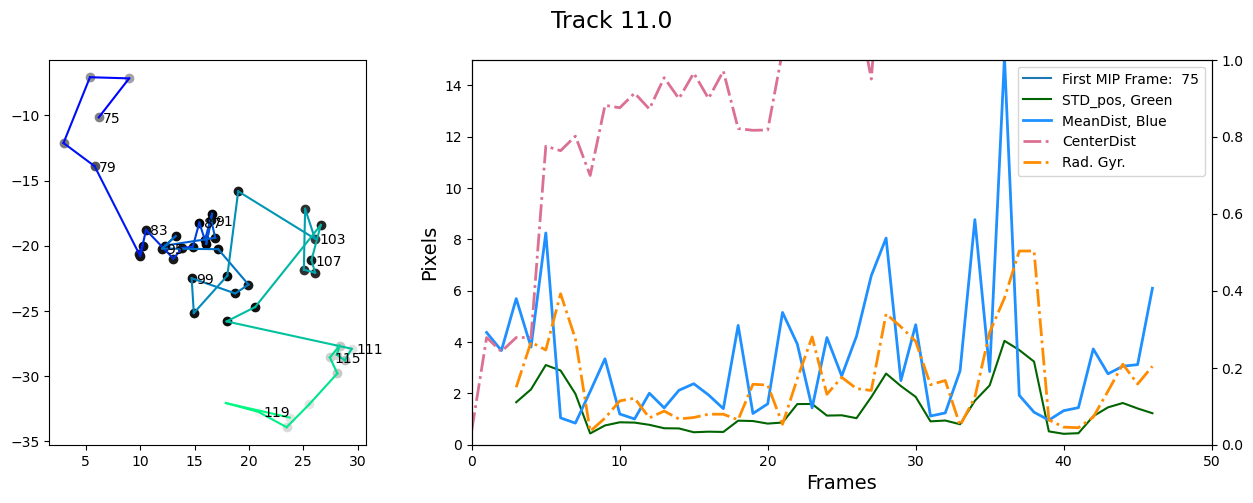

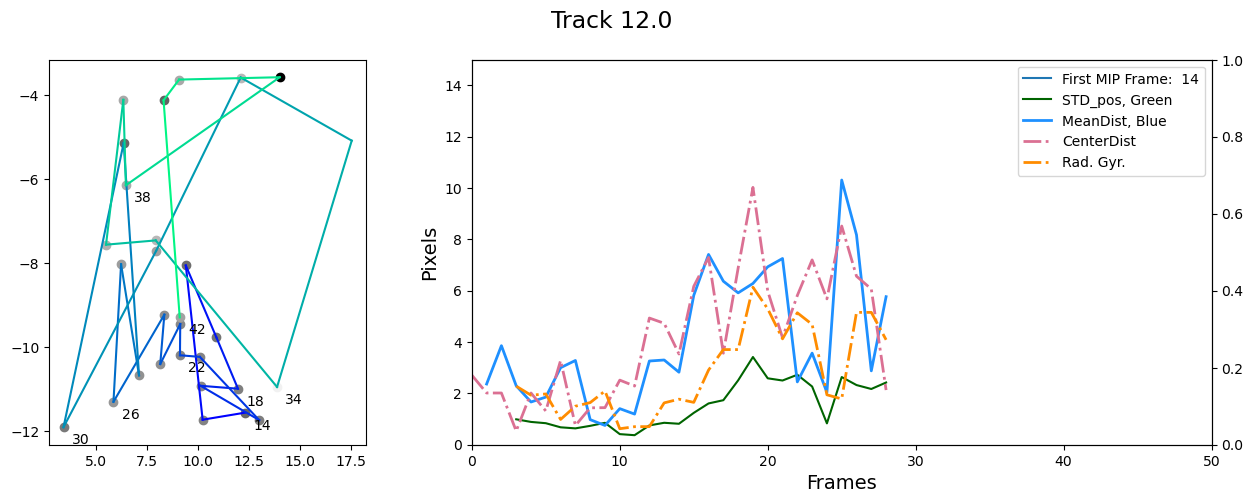

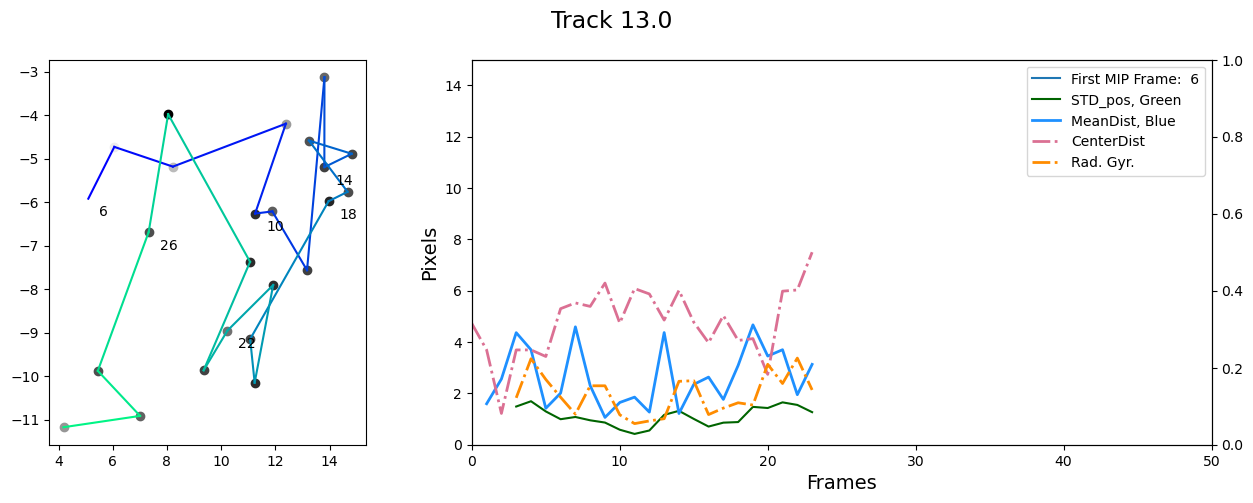

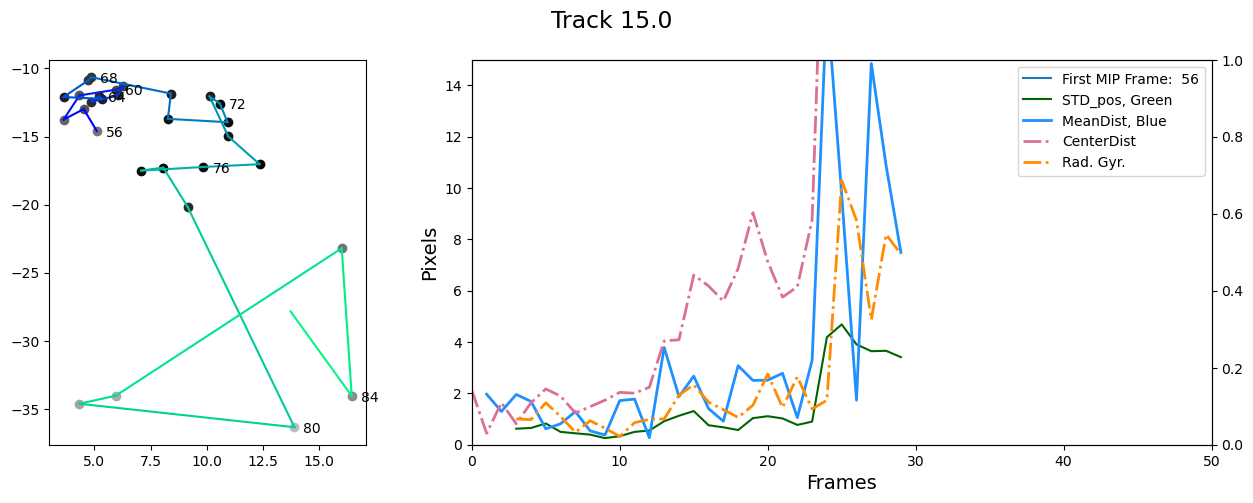

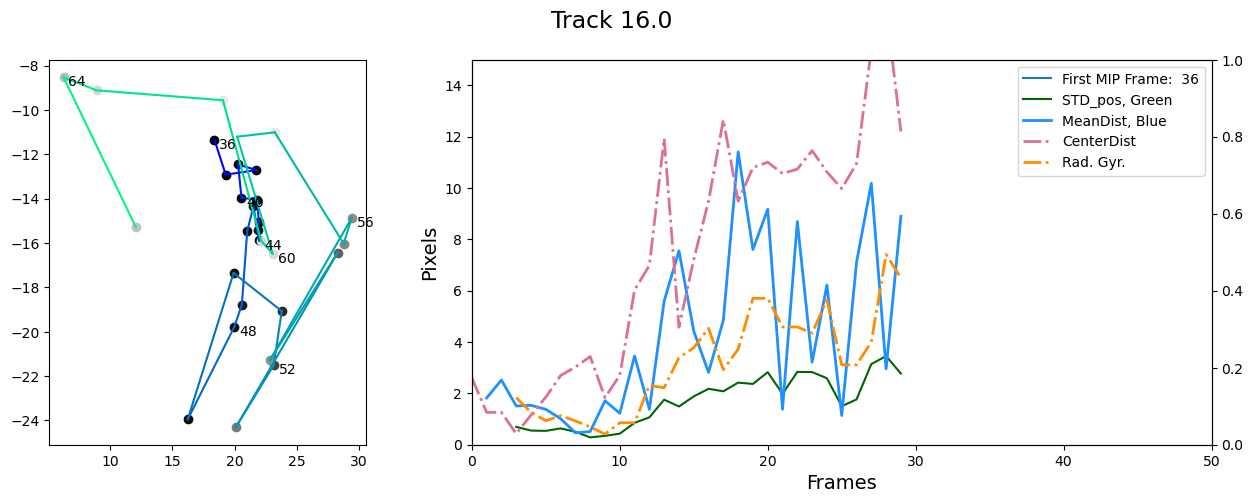

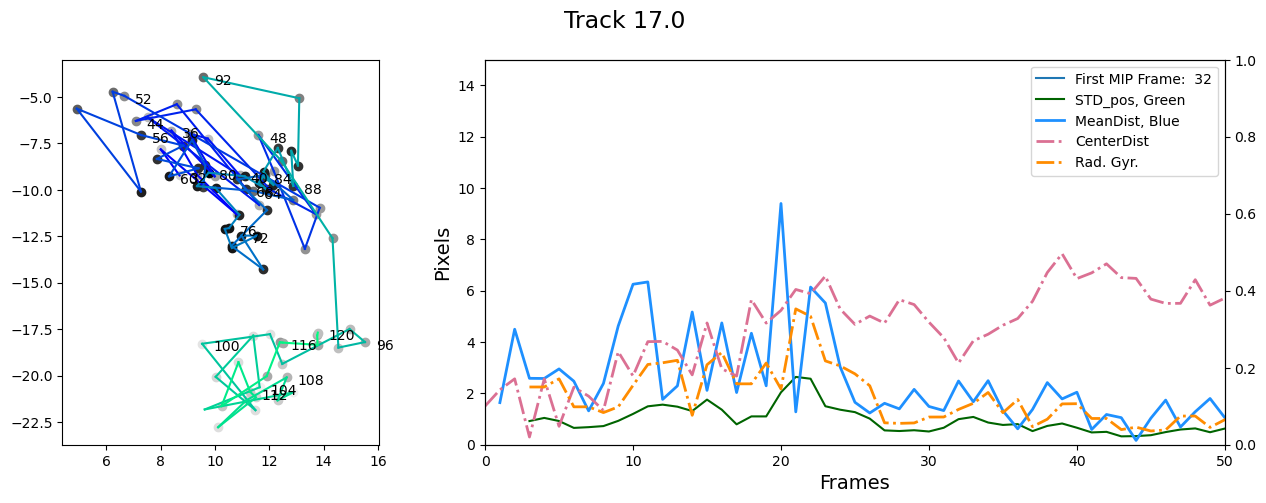

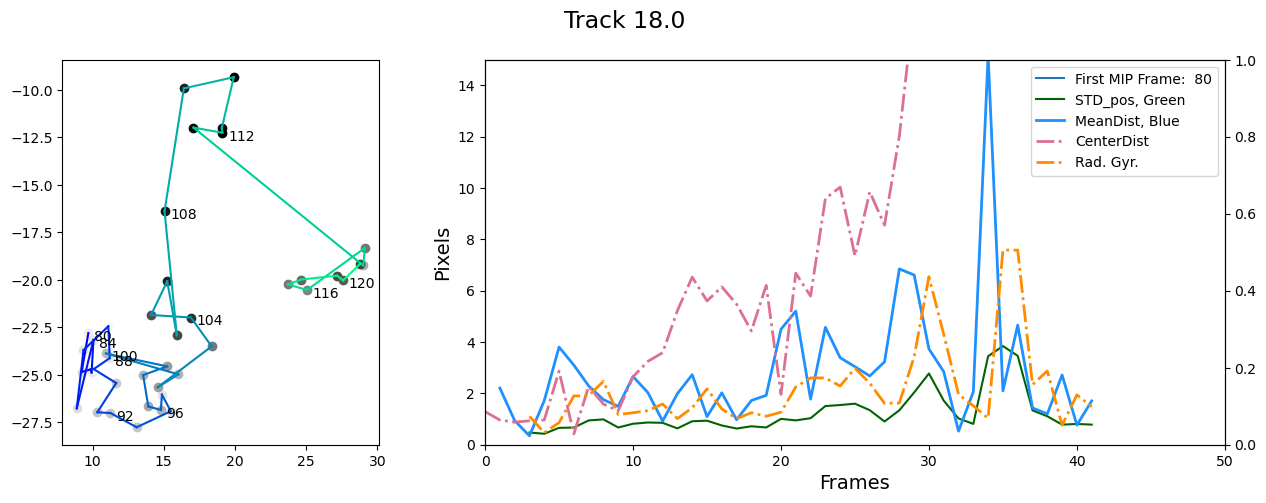

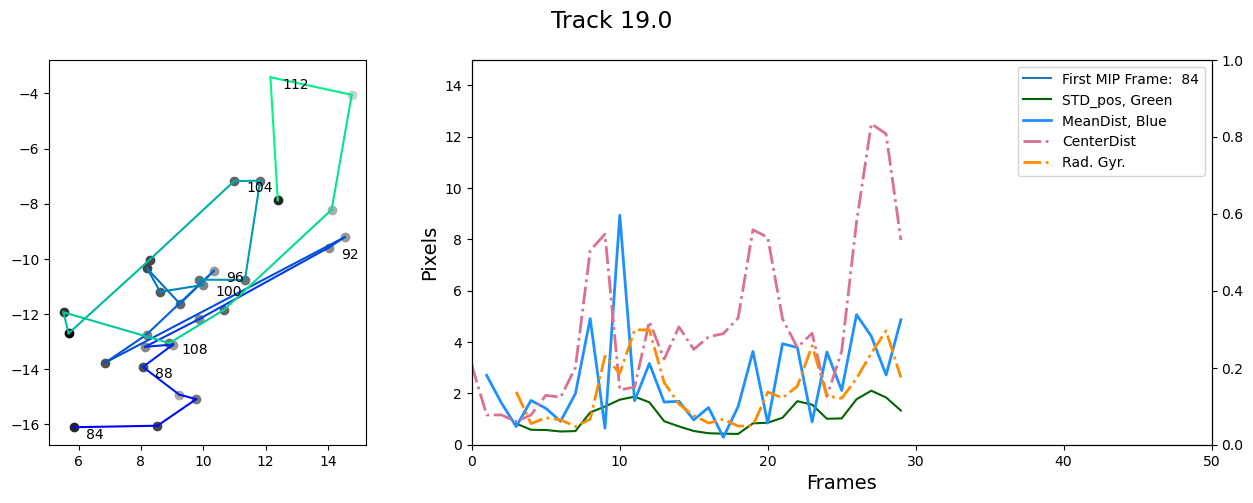

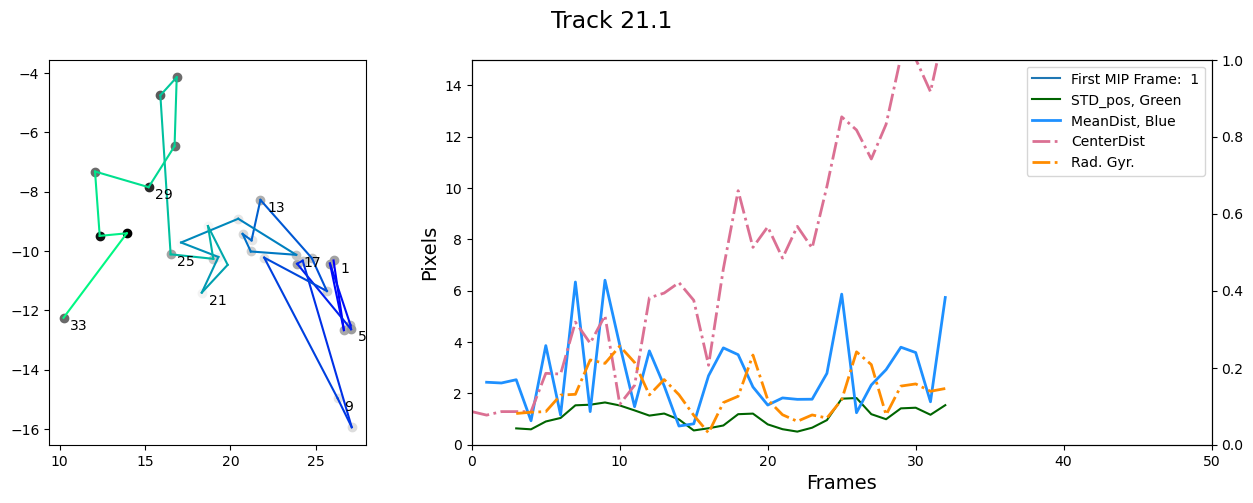

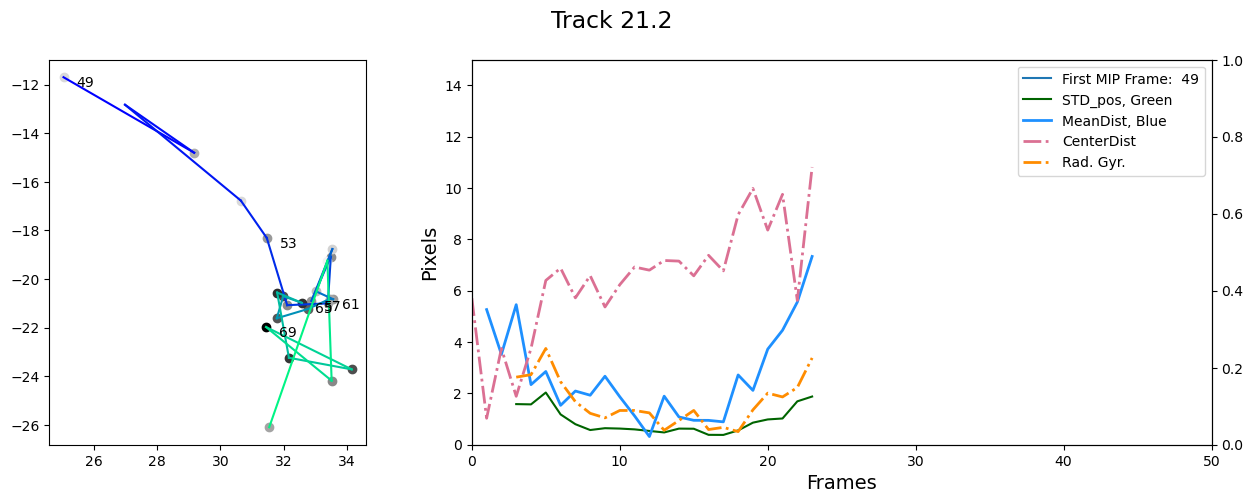

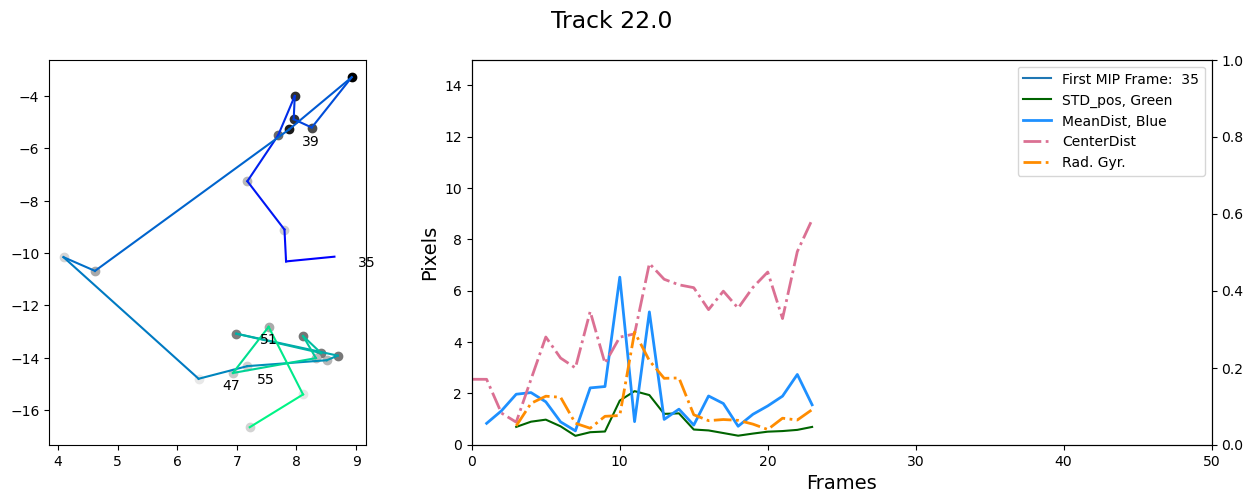

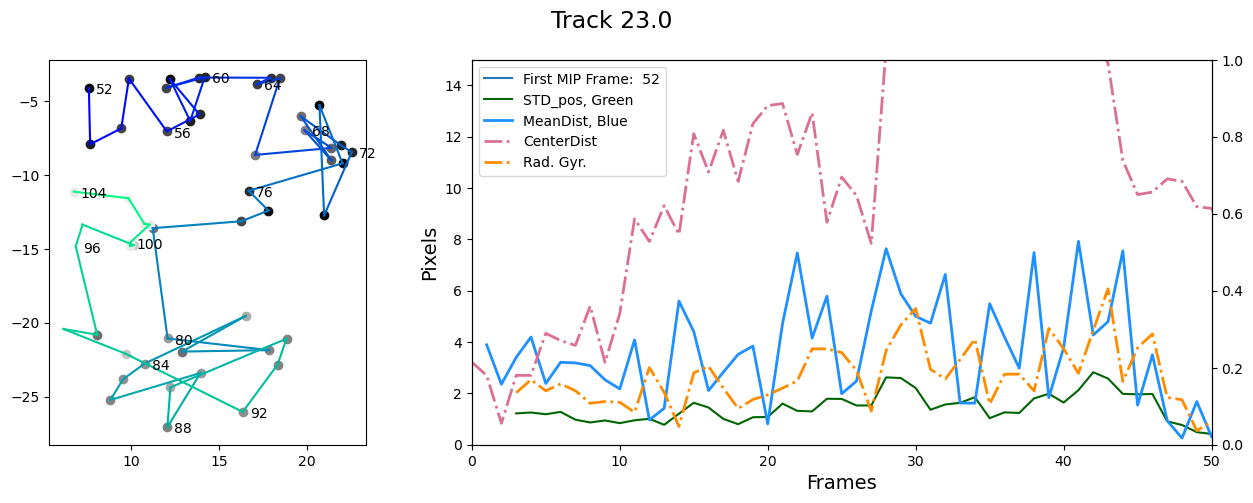

In [7]:
d = create_dictionary(df, track_nums_wanted)

d = metrics_dictionary(d, std_pos_param, cor_param, std_len_param, md_param, fluo_param)

d = radius_dictionary(d, first_frame, rad_window, shell, gyr_rad)

display_dictionary(d)

In [20]:
# Metrics: Uses CutoffList 

avgcutoff = mean([cutofflist[m][1] for m in range(len(cutofflist))]) # use in first cell: from statistics import mean

print("Times when cutoff was hit: " + str([cutofflist[m][1] for m in range(len(cutofflist))]))
print("Cell #s that never hit: " + str(zeroslist))
print("Imaging runs every " + str(imaging_window) + " seconds")
print("Average cutoff: " +str(avgcutoff))
print("Average time until cutoff: " + str(avgcutoff*imaging_window) + " seconds")

Times when cutoff was hit: [17, 14, 13, 12, 12, 15, 28, 10, 18, 6, 7, 20, 9]
Cell #s that never hit: []
Imaging runs every 10 seconds
Average cutoff: 13.923076923076923
Average time until cutoff: 139.23076923076923 seconds


In [21]:
# Save D: 

save_output = False

if save_output == True:

    concatenated_df = pd.concat(d.values(), axis=0)
    Output_excel_Path = '/Users/andrewperun/LusKing/PT_WT/PTWT_allData_10122023/01312023.xlsx'

    concatenated_df.to_excel(Output_excel_Path, index=False)